![title](https://img1.wsimg.com/isteam/ip/b0ab7975-9582-47f9-bf69-e0c9e612af38/Copy%20of%20LP%20(2).png)

## SageMaker Serverless Inference
## NFT-gan image generation model Example

Amazon SageMaker Serverless Inference is a purpose-built inference option that makes it easy for customers to deploy and scale ML models. Serverless Inference is ideal for workloads which have idle periods between traffic spurts and can tolerate cold starts. Serverless endpoints also automatically launch compute resources and scale them in and out depending on traffic, eliminating the need to choose instance types or manage scaling policies.

For this notebook we'll be working with the NFTgan image generation model to deploy as serverless endpoint

<b>Notebook Setting</b>
- <b>SageMaker Classic Notebook Instance</b>: ml.m5.xlarge Notebook Instance & conda_python3 Kernel
- <b>SageMaker Studio</b>: Python 3 (Data Science)
- <b>Regions Available</b>: SageMaker Serverless Inference is currently available in the following regions: US East (Northern Virginia), US East (Ohio), US West (Oregon), EU (Ireland), Asia Pacific (Tokyo) and Asia Pacific (Sydney)

## Table of Contents
- Setup
- Deployment
    - Model Creation
    - Endpoint Configuration (Adjust for Serverless)
    - Serverless Endpoint Creation
    - Endpoint Invocation
- Cleanup

## Setup

For testing you need to properly configure your Notebook Role to have <b>SageMaker Full Access</b>.

Let's start by installing preview wheels of the Python SDK, boto and aws cli

In [1]:
! pip install sagemaker botocore boto3 awscli --upgrade

     |████████████████████████████████| 481 kB 20.7 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 8.5 MB 67.8 MB/s            
     |████████████████████████████████| 131 kB 50.4 MB/s            
     |████████████████████████████████| 3.8 MB 71.1 MB/s            
  Created wheel for sagemaker: filename=sagemaker-2.74.0-py2.py3-none-any.whl size=663097 sha256=d5be8c77b6c8ded6599d75653ba0dd4713c7528dffe5f8af7461bc92fd0dafbb
  Stored in directory: /home/ec2-user/.cache/pip/wheels/f5/bb/44/be73dadfb93dd3774de868225341b84e46c952a934b8b7ab61
Successfully built sagemaker
  Attempting uninstall: botocore
    Found existing installation: botocore 1.23.25
    Uninstalling botocore-1.23.25:
      Successfully uninstalled botocore-1.23.25
  Attempting uninstall: boto3
    Found existing installation: boto3 1.20.25
    Uninstalling boto3-1.20.25:
      Successfully uninstalled boto3-1.20.25
  Attempting uninstall: sagemaker
    Found existing ins

In [3]:
# Setup clients
import boto3

client = boto3.client(service_name="sagemaker")
runtime = boto3.client(service_name="sagemaker-runtime")

### SageMaker Setup
To begin, we import the AWS SDK for Python (Boto3) and set up our environment, including an IAM role and an S3 bucket to store our data.

In [4]:
import boto3
import sagemaker
from sagemaker.estimator import Estimator

#create a boto3 session
boto_session = boto3.session.Session()
region = boto_session.region_name
print(region) # check the region

#creating sagemaker session
sagemaker_session = sagemaker.Session()
base_job_prefix = "NFT-GAN-serverless-infereance"
role = sagemaker.get_execution_role()
print(role) # checking the IM role of s3 access

default_bucket = sagemaker_session.default_bucket()
s3_prefix = base_job_prefix

#sellect instance as of now cpu instance
training_instance_type = "ml.t3.medium"

ap-southeast-2
arn:aws:iam::456800965054:role/service-role/AmazonSageMakerServiceCatalogProductsUseRole


## Select an Image to deploy the model

please visit https://github.com/aws/deep-learning-containers/blob/master/available_images.md to the list of avaliable images


In [10]:

# retrieve tensorflow image
image_uri = sagemaker.image_uris.retrieve(
    framework="tensorflow",
    region=region,
    version="2.1",
    py_version="py3",
    image_scope="inference",
    instance_type=training_instance_type,
)
image_uri

'763104351884.dkr.ecr.ap-southeast-2.amazonaws.com/tensorflow-inference:2.1-cpu'

## Create model


After training the model, retrieve the model artifacts so that we can deploy the model to an endpoint. the model should be saved in modelname.tar.gz formate

In [11]:
from time import gmtime, strftime

model_name = "NFTgenerator-serverless" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("Model name: " + model_name)

model_path = "s3://sagemaker-ap-southeast-2-456800965054/Models/NFT_gen.tar.gz"

create_model_response = client.create_model(
    ModelName=model_name,
    Containers=[
        {
            "Image": image_uri,
            "Mode": "SingleModel",
            "ModelDataUrl": model_path,
        }
    ],
    ExecutionRoleArn=role,
)

print("Model Arn: " + create_model_response["ModelArn"])

Model name: NFTgenerator-serverless2022-01-31-02-13-15
Model Arn: arn:aws:sagemaker:ap-southeast-2:456800965054:model/nftgenerator-serverless2022-01-31-02-13-15


### Endpoint Configuration Creation

This is where you can adjust the <b>Serverless Configuration</b> for your endpoint. The current max concurrent invocations for a single endpoint, known as <b>MaxConcurrency</b>, can be any value from <b>1 to 50</b>, and <b>MemorySize</b> can be any of the following: <b>1024 MB, 2048 MB, 3072 MB, 4096 MB, 5120 MB, or 6144 MB</b>.

In [12]:
NFTgenerator_epc_name = "NFTgenerator-serverless-epc" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

endpoint_config_response = client.create_endpoint_config(
    EndpointConfigName=NFTgenerator_epc_name,
    ProductionVariants=[
        {
            "VariantName": "NFTgenerator",
            "ModelName": model_name,
            "ServerlessConfig": {
                "MemorySizeInMB": 2048,
                "MaxConcurrency": 1,
            },
        },
    ],
)

print("Endpoint Configuration Arn: " + endpoint_config_response["EndpointConfigArn"])

Endpoint Configuration Arn: arn:aws:sagemaker:ap-southeast-2:456800965054:endpoint-config/nftgenerator-serverless-epc2022-01-31-02-31-53


### Serverless Endpoint Creation
Now that we have an endpoint configuration, we can create a serverless endpoint and deploy our model to it. When creating the endpoint, provide the name of your endpoint configuration and a name for the new endpoint.

In [13]:
endpoint_name = "NFTgenerator-serverless-ap" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

create_endpoint_response = client.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=NFTgenerator_epc_name,
)

print("Endpoint Arn: " + create_endpoint_response["EndpointArn"])

Endpoint Arn: arn:aws:sagemaker:ap-southeast-2:456800965054:endpoint/nftgenerator-serverless-ap2022-01-31-02-32-30


Wait until the endpoint status is InService before invoking the endpoint.

In [14]:
# wait for endpoint to reach a terminal state (InService) using describe endpoint
import time

describe_endpoint_response = client.describe_endpoint(EndpointName=endpoint_name)

while describe_endpoint_response["EndpointStatus"] == "Creating":
    describe_endpoint_response = client.describe_endpoint(EndpointName=endpoint_name)
    print(describe_endpoint_response["EndpointStatus"])
    time.sleep(15)

describe_endpoint_response

Creating
Creating
Creating
Creating
Creating
Creating
Creating
InService


{'EndpointName': 'NFTgenerator-serverless-ap2022-01-31-02-32-30',
 'EndpointArn': 'arn:aws:sagemaker:ap-southeast-2:456800965054:endpoint/nftgenerator-serverless-ap2022-01-31-02-32-30',
 'EndpointConfigName': 'NFTgenerator-serverless-epc2022-01-31-02-31-53',
 'ProductionVariants': [{'VariantName': 'NFTgenerator',
   'DeployedImages': [{'SpecifiedImage': '763104351884.dkr.ecr.ap-southeast-2.amazonaws.com/tensorflow-inference:2.1-cpu',
     'ResolvedImage': '763104351884.dkr.ecr.ap-southeast-2.amazonaws.com/tensorflow-inference@sha256:0803dbfa124acf1d43f1493f84d55a435e5894bbdd839fdefe20c750e815bca0',
     'ResolutionTime': datetime.datetime(2022, 1, 31, 2, 32, 31, 59000, tzinfo=tzlocal())}],
   'CurrentWeight': 1.0,
   'DesiredWeight': 1.0,
   'CurrentInstanceCount': 0,
   'CurrentServerlessConfig': {'MemorySizeInMB': 2048, 'MaxConcurrency': 1}}],
 'EndpointStatus': 'InService',
 'CreationTime': datetime.datetime(2022, 1, 31, 2, 32, 30, 385000, tzinfo=tzlocal()),
 'LastModifiedTime': dat

### Endpoint Invocation
Invoke the endpoint by sending a request to it. the following is a sample code to send random noise to Genrator and get the generated image


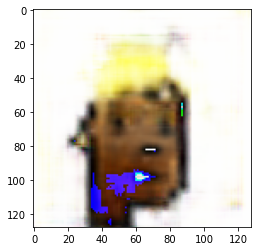

In [109]:
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt

PREVIEW_ROWS = 1
PREVIEW_COLS = 1
  
noice = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS,300))

data = json.dumps({"signature_name": "serving_default", "instances": noice.tolist()})
headers = {"content-type": "application/json"}


response = runtime.invoke_endpoint(
    EndpointName=endpoint_name,
    Body= data,
    ContentType="application/json"
)

try:
    image = np.array(json.loads(response["Body"].read())["predictions"])
    formatted_image = (image[0] * 255 / np.max(image[0])).astype('uint8')
except e:
        print(e)

plt.imshow(formatted_image)
plt.show
img = Image.fromarray(formatted_image, "RGB")
img.save("my.png")